# Análisis de sensibilidad final

Un requisito solicitado por el stakeholder era analizar el efecto que tiene la inclusión de una marca de agua en el rendimiento del modelo de predicción desarrollado. Una marca de agua es una señal que se agrega al dibujo realizado por el sujeto bajo estudio. Esta señal se suma a las coordenadas X y Y del dibujo del sujeto y permite determinar la autenticidad del dibujo. Ya existe un modelo que se encarga de generar esta marca de agua de tal forma que no se modifique demasiado el dibujo original. En este trabajo nuestros objetivos son dos:

1. Identificar el impacto que tiene la inclusión de la marca de agua en las señales X y Y originales, desde el punto de vista del poder predictivo del algoritmo desarrollado.
2. Determinar el rango de valores de la marca de agua que minimiza el impacto en el poder predictivo del algoritmo. De tal forma que estas medidas puedan utilizarse en el desarrollo del producto final por parte del stakeholder.

Por practicidad se ha determinado que la señal de marca de agua sea un ruido aleatorio dentro de un rango determinado de valores enteros pues las señales X y Y son de tipo entero y representan coordenadas. 

In [4]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import numpy as np
import pandas as pd

from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,
                             auc, roc_curve, det_curve, accuracy_score)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

# Bibliotecas para preprocesamiento y transformación
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importar clases de transformadores custom
from transformers import WaveletTransformer, LLETransformer, PCATransformer, StandardScalerTSTransformer
import os

In [5]:
# parameters for normalization
SCALE = 0.01
PROPORTION = 0.2

np.random.seed(42)

def load_data(raw_data_dir):
    """
    Carga los datos preprocesados del análisis exploratorio
    """
    X_train = pd.read_parquet(os.path.join(raw_data_dir, 'X_train.parquet'))
    y_train = pd.read_parquet(os.path.join(raw_data_dir, 'y_train.parquet'))
    X_val = pd.read_parquet(os.path.join(raw_data_dir, 'X_val.parquet'))
    y_val = pd.read_parquet(os.path.join(raw_data_dir, 'y_val.parquet'))
    X_test = pd.read_parquet(os.path.join(raw_data_dir, 'X_test.parquet'))
    y_test = pd.read_parquet(os.path.join(raw_data_dir, 'y_test.parquet'))
    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize_data(X, fit=False, state=None):
    """Normaliza los datos de entrada"""
    if fit:
        x_mean = X['x'].explode().mean()
        x_std = X['x'].explode().std()

        y_mean = X['y'].explode().mean()
        y_std = X['y'].explode().std()

        azimuth_mean = X['azimuth'].explode().mean()
        azimuth_std = X['azimuth'].explode().std()

        altitude_mean = X['altitude'].explode().mean()
        altitude_std = X['altitude'].explode().std()

        pressure_mean = X['pressure'].explode().mean()
        pressure_std = X['pressure'].explode().std()

        state = {
            'x_mean': x_mean,
            'x_std': x_std,
            'y_mean': y_mean,
            'y_std': y_std,
            'azimuth_mean': azimuth_mean,
            'azimuth_std': azimuth_std,
            'altitude_mean': altitude_mean,
            'altitude_std': altitude_std,
            'pressure_mean': pressure_mean,
            'pressure_std': pressure_std,
        }
    else:
        x_mean = state['x_mean']
        x_std = state['x_std']

        y_mean = state['y_mean']
        y_std = state['y_std']

        azimuth_mean = state['azimuth_mean']
        azimuth_std = state['azimuth_std']

        altitude_mean = state['altitude_mean']
        altitude_std = state['altitude_std']

        pressure_mean = state['pressure_mean']
        pressure_std = state['pressure_std']

    # normalized train data
    normalized_x = (X['x'] - x_mean) / x_std
    normalized_y = (X['y'] - y_mean) / y_std
    azimuth = (X['azimuth'] - azimuth_mean) / azimuth_std
    altitude = (X['altitude'] - altitude_mean) / altitude_std
    pressure = (X['pressure'] - pressure_mean) / pressure_std

    new_X = pd.concat([X[['homework','pen_status']], normalized_x, normalized_y, azimuth, altitude, pressure], axis=1)

    return new_X, state

def augment_data(features_df, labels_df):
    qty_rows_to_augment = int(PROPORTION * features_df.shape[0])
    df_augmented = features_df.copy()
    df_augmented_labels = labels_df.copy()

    for _ in range(qty_rows_to_augment):  # Create new N data
        target_row = np.random.randint(0, features_df.shape[0] - 1)  # Randomly select a row
        original_x_y_arrays = features_df.iloc[target_row][['x_and_y']].values

        # Generate Gaussian noise with the same shape as the selected row
        random_noise_x = np.random.normal(0, SCALE, size=original_x_y_arrays[0].shape)
        new_x_data = original_x_y_arrays[0].shape + random_noise_x  # Add noise

        # Convert to DataFrame and maintain original structure
        augmented_row = {
            'x_and_y': new_x_data,
            'homework': features_df.iloc[target_row]['homework'],
            'pen_status': features_df.iloc[target_row]['pen_status'],
        }
        augmented_row = pd.DataFrame([augmented_row])

        augmented_row_label = pd.DataFrame([labels_df.iloc[target_row]])

        # Concatenate the augmented row to the original dataset
        df_augmented = pd.concat([df_augmented, augmented_row], ignore_index=True, axis=0)
        df_augmented_labels = pd.concat([df_augmented_labels, augmented_row_label], ignore_index=True, axis=0)

    return df_augmented, df_augmented_labels

def create_preprocessing_pipeline(reduction_method='lle', numerical_columns=['x', 'y']):
    preprocessing_pipeline = None
    if reduction_method == 'lle':
        preprocessing_pipeline = Pipeline([
            ('wavelet', WaveletTransformer(wavelet='sym5', level=30)),
            ('lle', LLETransformer(n_components=40, n_neighbors=5, eigen_solver='dense'))
        ])
    elif reduction_method == 'pca':
        preprocessing_pipeline = Pipeline([
            ('wavelet', WaveletTransformer(wavelet='db4', level=20)),
            ('norm', StandardScalerTSTransformer()),
            ('pca', PCATransformer())
        ])

    preprocesador = ColumnTransformer(
        transformers=[
            ('numericas', preprocessing_pipeline, numerical_columns)
        ],
        remainder='passthrough'
    )
    return preprocesador

def print_classification_report(y_true, y_pred, y_prob, label=""):
    print(f"{label} Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"{label} ROC AUC: {roc_auc:.4f}")

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    print(f"{label} Precision-Recall AUC: {pr_auc:.4f}")


In [6]:
print("Cargando datos...")
X_train, y_train, X_val, y_val, X_test, y_test = load_data(raw_data_dir='../data/raw_binary')
print("Normalizando datos...")

normalized_train_df, normalization_state = normalize_data(X_train, fit=True)
normalized_train_df['x_and_y'] = normalized_train_df.apply(lambda x: np.concatenate((x['azimuth'], x['altitude'], x['pressure'], x['x'], x['y'])), axis=1)
# Aumentar datos
df_augmented, y_train_augmented = augment_data(normalized_train_df, y_train)
# Crear y ajustar pipeline
print("Creando pipeline...")
pipeline = create_preprocessing_pipeline(reduction_method='lle', numerical_columns=['x_and_y'])
X_train_preprocessed = pipeline.fit_transform(df_augmented)
# Convertir a DataFrame para mejor manejo
columns = [f'caracteristica_{i}' for i in range(X_train_preprocessed.shape[1])]
X_train_transformed = pd.DataFrame(X_train_preprocessed, columns=columns)
all_features_train = pd.DataFrame(X_train_transformed['caracteristica_0'].to_list())
all_features_train.columns = [f"feature_{i}" for i in range(all_features_train.shape[1])]

best_parameters = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.}
best_xgb = XGBClassifier(**best_parameters, random_state=42)
best_xgb.fit(all_features_train, y_train_augmented['depression'])

# VALIDACIÓN DE MÉTRICA OBJETIVO SIN MARCA DE AGUA
X_val_normalized, _ = normalize_data(X_val, fit=False, state=normalization_state)
X_val_normalized['x_and_y'] = X_val_normalized.apply(lambda x: np.concatenate((x['azimuth'], x['altitude'], x['pressure'], x['x'], x['y'])), axis=1)
X_val_preprocessed = pipeline.transform(X_val_normalized)
X_val_transformed = pd.DataFrame(X_val_preprocessed, columns=columns)
all_features_val = pd.DataFrame(X_val_transformed['caracteristica_0'].to_list())
all_features_val.columns = [f"feature_{i}" for i in range(all_features_val.shape[1])]
y_pred_best_xgb = best_xgb.predict(all_features_val)
y_prob_best_xgb = best_xgb.predict_proba(all_features_val)[:, 1]
print_classification_report(y_val['depression'], y_pred_best_xgb, y_prob_best_xgb, label="XGBoost Depression (Tuned)")



# X_test, _ = normalize_data(X_test, fit=False, state=normalization_state)
# X_test['x_and_y'] = X_test.apply(lambda x: np.concatenate((x['azimuth'], x['altitude'], x['pressure'], x['x'], x['y'])), axis=1)
# X_test_preprocessed = pipeline.transform(X_test)
# X_test_transformed = pd.DataFrame(X_test_preprocessed, columns=columns)
# all_features_test = pd.DataFrame(X_test_transformed['caracteristica_0'].to_list())
# all_features_test.columns = [f"feature_{i}" for i in range(all_features_test.shape[1])]


Cargando datos...
Normalizando datos...
Creando pipeline...
XGBoost Depression (Tuned) Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.96      0.84       408
        True       0.45      0.10      0.17       148

    accuracy                           0.73       556
   macro avg       0.60      0.53      0.50       556
weighted avg       0.67      0.73      0.66       556

XGBoost Depression (Tuned) ROC AUC: 0.5929
XGBoost Depression (Tuned) Precision-Recall AUC: 0.3323


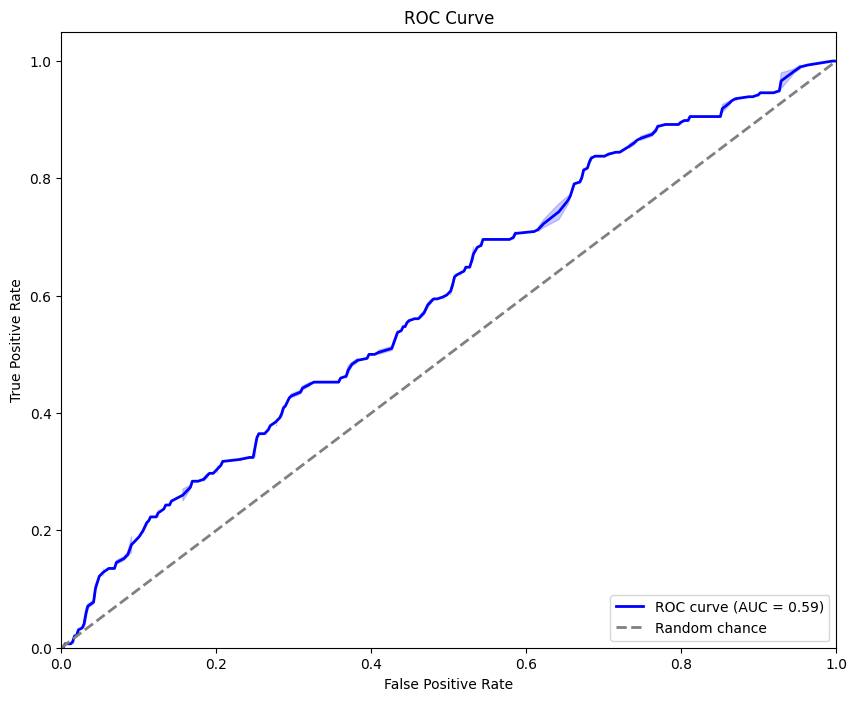

In [7]:
# Calculate ROC curve
label = 'depression'
fpr, tpr, thresholds = roc_curve(y_val[label], y_prob_best_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
sns.lineplot(x=fpr, y=tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Watermarking sensitivity

Se utilizan magnitudes de ruido crecientes desde 1 hasta 800, en este caso representan una modificación máxima de hasta 800 puntos enteros (coordenadas) en la señal tanto X como Y.

In [166]:

def apply_watermark(X, intensity=0):
    # apply watermark to x and y columns
    X_ = X.copy()
    X_['x'] = X_.apply(lambda x: x['x'] + np.random.random_integers(intensity, size=x['x'].shape), axis=1)

    X_['y'] = X_.apply(lambda x: x['y'] + np.random.random_integers(intensity, size=x['y'].shape), axis=1)


    std_dev_df = pd.concat((X_[['x','y']], X[['x','y']]), axis=1)
    std_dev_df.columns = ['x_noise', 'y_noise', 'x', 'y']

    std_dev_df['sigma'] = std_dev_df.apply(lambda x: np.std(x['x_noise']/np.std(x['x'])), axis=1)

    


    return X_, np.mean(std_dev_df['sigma'])


def evaluate_watermark_impact():
    accuracy_history = []
    positive_class_precision_history = []
    roc_history = []
    sigma_history = []
    for intensity in range(1, 800, 20):
        print("########## \nNoise Level: ", intensity)
        X_val_watermarked, sigma = apply_watermark(X_val, intensity=intensity)
        X_val_normalized, _ = normalize_data(X_val_watermarked, fit=False, state=normalization_state)
        X_val_normalized['x_and_y'] = X_val_normalized.apply(lambda x: np.concatenate((x['azimuth'], x['altitude'], x['pressure'], x['x'], x['y'])), axis=1)
        X_val_preprocessed = pipeline.transform(X_val_normalized)
        X_val_transformed = pd.DataFrame(X_val_preprocessed, columns=columns)
        all_features_val = pd.DataFrame(X_val_transformed['caracteristica_0'].to_list())
        all_features_val.columns = [f"feature_{i}" for i in range(all_features_val.shape[1])]
        y_pred_best_xgb = best_xgb.predict(all_features_val)
        y_prob_best_xgb = best_xgb.predict_proba(all_features_val)[:, 1]
        # print_classification_report(y_val['depression'], y_pred_best_xgb, y_prob_best_xgb, label="XGBoost Depression (Tuned)")
        # print("Accuracy Score: ", accuracy_score(y_val['depression'], y_pred_best_xgb))
        accuracy = accuracy_score(y_val['depression'], y_pred_best_xgb)
        positive_class_precision = classification_report(y_val['depression'], y_pred_best_xgb, zero_division=0, output_dict=True)['True']['precision']
        roc_auc = roc_auc_score(y_val['depression'], y_prob_best_xgb)

        print("Accuracy: ", accuracy)
        print("Positive Class Precision: ", positive_class_precision)
        print(f"{label} ROC AUC: {roc_auc:.4f}")

        accuracy_history.append(accuracy)
        positive_class_precision_history.append(positive_class_precision)
        roc_history.append(roc_auc)
        sigma_history.append(sigma)



    return accuracy_history, positive_class_precision_history, roc_history, sigma_history, X_val_watermarked

accuracy_score_history, positive_class_precision_history, roc_history, sigma_history, last_images = evaluate_watermark_impact()


########## 
Noise Level:  1
Accuracy:  0.7284172661870504
Positive Class Precision:  0.45454545454545453
depression ROC AUC: 0.5943
########## 
Noise Level:  21
Accuracy:  0.7302158273381295
Positive Class Precision:  0.46875
depression ROC AUC: 0.5886
########## 
Noise Level:  41
Accuracy:  0.7338129496402878
Positive Class Precision:  0.5
depression ROC AUC: 0.5892
########## 
Noise Level:  61
Accuracy:  0.737410071942446
Positive Class Precision:  0.5333333333333333
depression ROC AUC: 0.5888
########## 
Noise Level:  81
Accuracy:  0.7392086330935251
Positive Class Precision:  0.5517241379310345
depression ROC AUC: 0.5897
########## 
Noise Level:  101
Accuracy:  0.7356115107913669
Positive Class Precision:  0.5185185185185185
depression ROC AUC: 0.5805
########## 
Noise Level:  121
Accuracy:  0.7338129496402878
Positive Class Precision:  0.5
depression ROC AUC: 0.5848
########## 
Noise Level:  141
Accuracy:  0.7338129496402878
Positive Class Precision:  0.5
depression ROC AUC: 0.596

Text(0, 0.5, 'Noise level (sigma)')

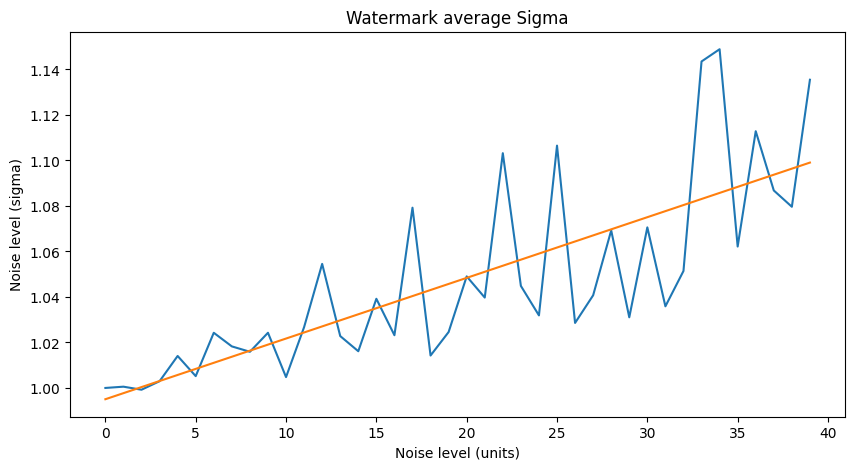

In [167]:
plt.plot(sigma_history)
coeffs = np.polyfit(range(len(sigma_history)),sigma_history,1)

def sigma_approximation(x):
    return coeffs[0]*x + coeffs[1]

watermark_sigma = sigma_approximation(range(len(sigma_history)))

plt.plot(watermark_sigma)
plt.title("Watermark average Sigma")
plt.xlabel("Noise level (units)")
plt.ylabel("Noise level (sigma)")

Text(0, 0.5, 'Metric value')

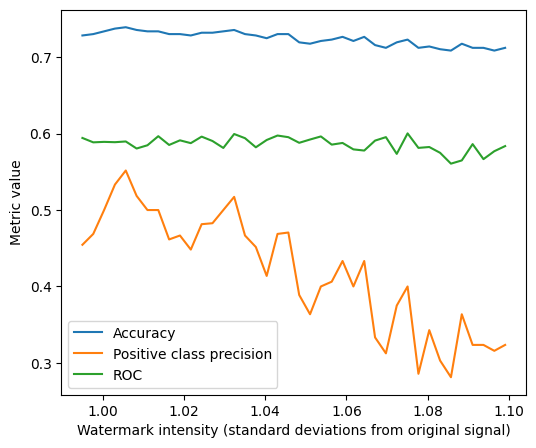

In [168]:
noise_range = range(1, 800, 20)
from pylab import rcParams
rcParams['figure.figsize'] = 6,5
plt.plot(watermark_sigma, accuracy_score_history)
plt.plot(watermark_sigma, positive_class_precision_history)
plt.plot(watermark_sigma, roc_history)
plt.legend(['Accuracy', 'Positive class precision', 'ROC'])
plt.xlabel('Watermark intensity (standard deviations from original signal)')
plt.ylabel('Metric value')

Text(0, 0.5, 'y coordinate')

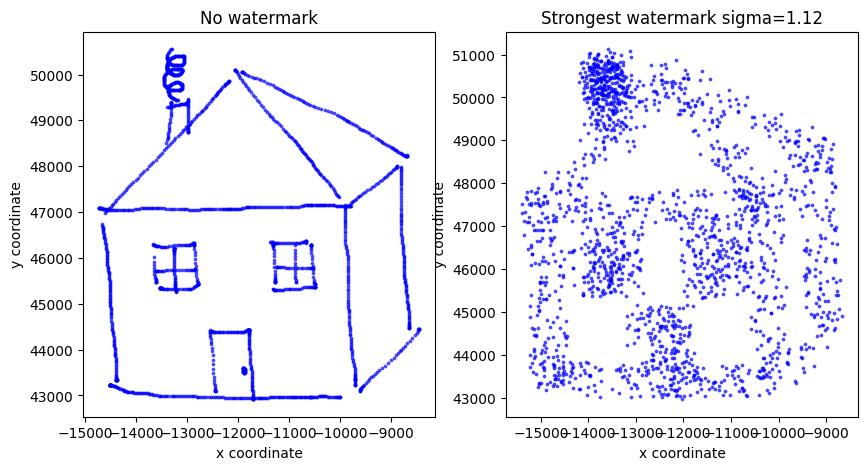

In [169]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

fig, ax = plt.subplots(1,2)
ax[0].scatter(-X_val.iloc[1]['y'], X_val.iloc[1]['x'], s=3, c='blue', alpha=0.6)
ax[0].set_title("No watermark")
ax[0].set_xlabel("x coordinate")
ax[0].set_ylabel("y coordinate")
ax[1].scatter(-last_images.iloc[1]['y'], last_images.iloc[1]['x'], s=3, c='blue', alpha=0.6)
ax[1].set_title("Strongest watermark sigma=1.12")
ax[1].set_xlabel("x coordinate")
ax[1].set_ylabel("y coordinate")


**Conclusiones:**

- La marca de agua afecta negativamente la precisión de la clase positiva (estrés), es decir que aumenta el error tipo 1.
- El aumento del error tipo 1 implica que la adición de la marca de agua impacta aumentando la cantidad de falsos positivos, es decir que el itmo clasifica como estresados a individuos que en realidad no lo están.

# Análisis de rangos seguros para adición de marcas de agua

In [174]:
noise_range = range(1, 800, 20)

Magnitud promedio de ruido:  1.085717251502702 Sigma
Magnitud máxima de ruido:  681 unidades de coordenadas


Text(0.5, 1.0, 'Watermark safe region')

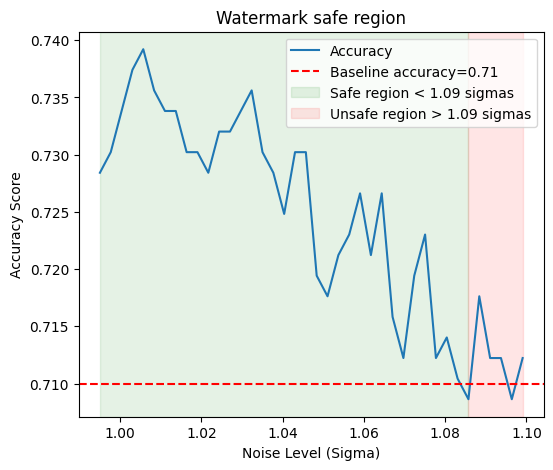

In [183]:
baseline_accuracy = 0.71
intersection_noise_sigma = 0
intersection_noise_level = 0
for noise_level, sigma, accuracy in zip(noise_range, watermark_sigma, accuracy_score_history):
    if accuracy < baseline_accuracy:
        intersection_noise_sigma = sigma
        intersection_noise_level = noise_level
        break

print("Magnitud promedio de ruido: ", intersection_noise_sigma, "Sigma")
print("Magnitud máxima de ruido: ", intersection_noise_level, "unidades de coordenadas")

rcParams['figure.figsize'] = 6,5
plot = plt.plot(watermark_sigma, accuracy_score_history)

plt.axhline(y = 0.71, color = 'r', linestyle = '--')

plt.axvspan(watermark_sigma[0], intersection_noise_sigma, alpha=0.1, color="green")
plt.axvspan(intersection_noise_sigma, watermark_sigma[-1], alpha=0.1, color="red")
plt.legend(['Accuracy', f'Baseline accuracy={baseline_accuracy}', f'Safe region < {intersection_noise_sigma:.2f} sigmas', f'Unsafe region > {intersection_noise_sigma:.2f} sigmas'])
plt.xlabel("Noise Level (Sigma)")
plt.ylabel("Accuracy Score")
plt.title("Watermark safe region")


Considerando que de forma minima se busca obtener el rendimiento baseline presentado en el paper (Nolazco-Flores et al., 2021) para la clase de depresión, se considera que un valor de hasta

# Pasos para el futuro

- Utilizar otras señales como marca de agua para cuantificar su efecto y determinar rangos seguros de uso que no afecten la métrica objetivo de predicción.
- Utilizar otros modelos para determinar su sensibilidad ante la marca de agua y determinar rangos seguros de uso.

